In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import glob
import matplotlib.pyplot as plt

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class SongDataSet_Image(Dataset):
    def __init__(self, file_dir, num_classes=21, segment_length=370):
        self.file_path = []
        self.num_classes = num_classes
        self.segment_length = segment_length

        for file in os.listdir(file_dir):
            self.file_path.append(os.path.join(file_dir, file))

    def __getitem__(self, index):
        file_path = self.file_path[index]
        data = np.load(file_path, allow_pickle=True)
        spectogram = data['s']

        ground_truth_labels = data['labels']

        # Z-score normalization
        mean_val = spectogram.mean()
        std_val = spectogram.std()
        spectogram = (spectogram - mean_val) / (std_val + 1e-7)  # Adding a small constant to prevent division by zero
        
        # Replace NaN values with zeros
        spectogram[np.isnan(spectogram)] = 0

        # Convert to tensor
        spectogram = torch.from_numpy(spectogram).float().permute(1, 0)  # Bringing spectrogram to length x height


        ground_truth_labels = torch.tensor(ground_truth_labels, dtype=torch.int64).squeeze(0)

        # Convert label to one-hot encoding
        ground_truth_labels = F.one_hot(ground_truth_labels, num_classes=self.num_classes).float()

        return spectogram, ground_truth_labels 

    def __len__(self):
        return len(self.file_path)

class CollateFunction:
    def __init__(self, segment_length=370):
        self.segment_length = segment_length

    def __call__(self, batch):
        # Unzip the batch (a list of (spectrogram, ground_truth_labels) tuples)
        spectrograms, ground_truth_labels = zip(*batch)

        # Create lists to hold the processed tensors
        spectrograms_processed = []
        ground_truth_labels_processed = []

        # Each sample in batch
        for spectrogram, ground_truth_label in zip(spectrograms, ground_truth_labels):
            # Truncate if larger than context window or take random window
            if spectrogram.shape[0] > self.segment_length:
                start = torch.randint(0, spectrogram.shape[0] - self.segment_length, (1,)).item()
                end = start + self.segment_length
                spectrogram = spectrogram[start:end]
                ground_truth_label = ground_truth_label[start:end]
            elif spectrogram.shape[0] < self.segment_length:
                # Pad with 0s if shorter
                pad_amount = self.segment_length - spectrogram.shape[0]
                spectrogram = F.pad(spectrogram, (0, 0, 0, pad_amount), 'constant', 0)
                ground_truth_label = F.pad(ground_truth_label, (0, 0, 0, pad_amount), 'constant', 0)

            # Append the processed tensors to the lists
            spectrograms_processed.append(spectrogram)
            ground_truth_labels_processed.append(ground_truth_label)

        # Stack tensors along a new dimension
        spectrograms = torch.stack(spectrograms_processed, dim=0)
        ground_truth_labels = torch.stack(ground_truth_labels_processed, dim=0)

        # Final reshape for model
        spectrograms = spectrograms.unsqueeze(1).permute(0, 1, 3, 2)

        return spectrograms, ground_truth_labels

In [3]:
from torch.utils.data import DataLoader

train_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/train"
test_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/test"

train_dataset = SongDataSet_Image(train_dir)
test_dataset = SongDataSet_Image(test_dir)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

(32000, 1)
(32000, 1)


/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


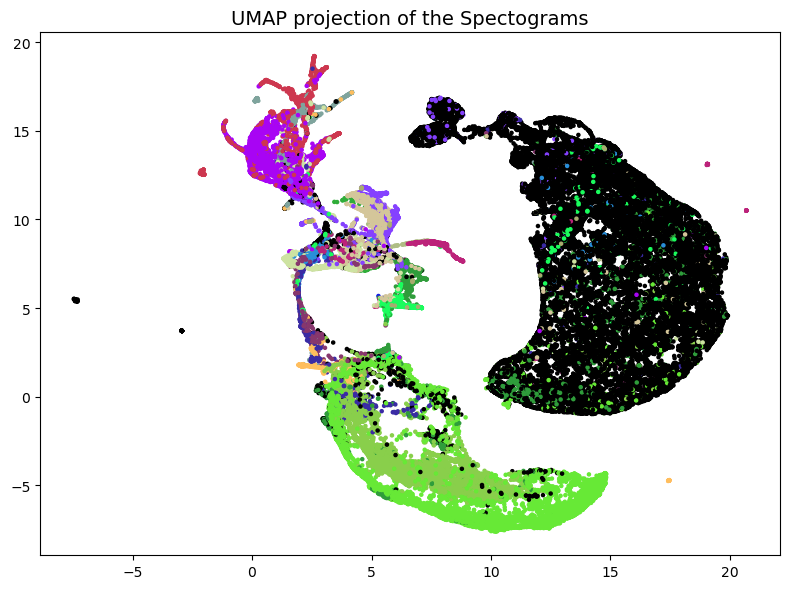

In [17]:
reductions_dims = 171

import pickle 
import umap

list_of_data = []
list_of_ground_truth = []

for i,  (data, ground_truth_label) in enumerate(train_loader):
    data = data[:,0,:,:]
    data = data.permute(0,2,1)
    ground_truth_label = ground_truth_label.argmax(-1)
    data = data.cpu().numpy()
    ground_truth_label = ground_truth_label.cpu().numpy()
    ground_truth_label = ground_truth_label.reshape(-1,1)
    data = data.reshape(-1,1 * 513)
    list_of_data.append(data)
    list_of_ground_truth.append(ground_truth_label)

    print(ground_truth_label.shape)

    if i > 0:
        break

list_of_data = list_of_data[:5000]
list_of_ground_truth = list_of_ground_truth[:5000]


list_of_data = np.concatenate(list_of_data, axis=0)
list_of_ground_truth = np.concatenate(list_of_ground_truth, axis=0)

# color stuff #
file_path = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/category_colors_llb16.pkl"
with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

colors_for_points = []
for label_row in list_of_ground_truth:
    if label_row.ndim > 0:
        # If label_row is iterable (more than one dimension)
        row_colors = [label_to_color[int(lbl)] for lbl in label_row]
        avg_color = np.mean(row_colors, axis=0)
    else:
        # If label_row is a single integer (one dimension)
        avg_color = label_to_color[int(label_row)]
    colors_for_points.append(avg_color)


reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.05, n_components=2, metric='euclidean')
embedding_outputs = reducer.fit_transform(list_of_data)

# Create the plot
fig = plt.figure(figsize=(8, 6))
plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_points)
plt.title(f'UMAP projection of the Spectograms', fontsize=14)
plt.tight_layout()
plt.show()


In [15]:
## Classifier

import torch.nn as nn

class UMAPClassifier(nn.Module):
    def __init__(self, num_classes):
        super(UMAPClassifier, self).__init__()  # This line is necessary
        self.classifier = nn.Linear(2, num_classes)

    def forward(self, input):
        logits = self.classifier(input)
        return logits
    
    def cross_entropy_loss(self, predictions, targets):
        loss = nn.CrossEntropyLoss()
        return loss(predictions, targets)

num_classes = 21
model = UMAPClassifier(num_classes)


In [16]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-1, weight_decay=0.0)

# Training setup
batches_per_eval = 1  # Evaluate after every 100 batches
total_batches = 0  # Total number of batches processed
desired_total_batches = 100  # Set your desired total number of batches
total_loss = 0  # Initialize total loss

cuda:0
Number of parameters: 63


In [13]:
# Early stopping parameters
patience = 100  # Number of validations to wait for improvement
num_val_no_improve = 0  # Counter for validations since last improvement
best_val_loss = float('inf')  # Best observed validation loss
stop_training = False  # Flag to stop training

In [14]:
import torch
import matplotlib.pyplot as plt

# Assuming other necessary imports and model setup are done above this

def frame_error_rate(y_pred, y_true):
    """
    Compute the frame error rate.
    y_pred: Tensor of shape (batch_size, num_classes, time_steps) - typically the output of a softmax
    y_true: Tensor of shape (batch_size, time_steps) - ground truth labels
    Returns the frame error rate.
    """

    y_pred = y_pred.argmax(-1)
    y_true = y_true.argmax(-1)
    mismatches = (y_pred != y_true).float()  # y_true is already in the correct format

    error = mismatches.sum() / y_true.size(0) 
    return error * 100

def validate_model(model, test_loader):
    model.eval()
    total_val_loss = 0
    total_frame_error = 0
    num_val_batches = 0
    with torch.no_grad():
        for i, (spectrogram, label) in enumerate(test_loader):
            if i > batches_per_eval:
                break

            label = label.to(device)

            spectrogram = spectrogram[:,0,:,:]
            spectrogram = spectrogram.permute(0,2,1)
            spectrogram = spectrogram.reshape(-1,1 * 513)
            label = label.reshape(-1,num_classes)

            spectrogram = reducer.transform(spectrogram)
            spectrogram = torch.Tensor(spectrogram)
            spectrogram = spectrogram.to(device)

            output = model.forward(spectrogram)

            loss = model.cross_entropy_loss(predictions=output, targets=label)

            total_val_loss += loss.item()
            total_frame_error += frame_error_rate(output, label).item()
            num_val_batches += 1

    return total_val_loss / num_val_batches, total_frame_error / num_val_batches

initial_val_loss, initial_frame_error = validate_model(model, test_loader)

# Initialize lists for storing raw and moving average data
loss_list, val_loss_list, frame_error_rate_list = [initial_val_loss], [initial_val_loss], [initial_frame_error]
loss_buffer, val_loss_buffer, frame_error_buffer = [], [], []


while total_batches < desired_total_batches:
    for i, (spectrogram, label) in enumerate(train_loader):
        if total_batches >= desired_total_batches:
            break

        label = label.to(device)

        spectrogram = spectrogram[:,0,:,:]
        spectrogram = spectrogram.permute(0,2,1)
        spectrogram = spectrogram.reshape(-1,1 * 513)
        label = label.reshape(-1,num_classes)

        spectrogram = reducer.transform(spectrogram)
        spectrogram = torch.Tensor(spectrogram)
        spectrogram = spectrogram.to(device)

        output = model.forward(spectrogram)

        loss = model.cross_entropy_loss(predictions=output, targets=label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_batches += 1
        loss_buffer.append(loss.item())

        if total_batches % batches_per_eval == 0:
            avg_val_loss, avg_frame_error = validate_model(model, test_loader)

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                num_val_no_improve = 0
            else:
                num_val_no_improve += 1
                if num_val_no_improve >= patience:
                    print("Early stopping triggered")
                    stop_training = True
                    break

            for times in range(batches_per_eval):
                val_loss_buffer.append(avg_val_loss)
                frame_error_buffer.append(avg_frame_error)

                # Calculate dynamic moving averages
                window_size = min(total_batches, 10)  # Use the smaller of total_batches or 10
                loss_list.append(np.mean(loss_buffer[-window_size:]))
                val_loss_list.append(np.mean(val_loss_buffer[-window_size:]))
                frame_error_rate_list.append(np.mean(frame_error_buffer[-window_size:]))

            if loss_list and val_loss_list and frame_error_rate_list:
                print(f'After {total_batches} batches, Training Loss: {loss_list[-1]:.2e}, Validation Loss: {val_loss_list[-1]:.2e}, Frame Error Rate: {frame_error_rate_list[-1]:.2f}%')
        
    if stop_training == True:
        break 

# Plotting the results with moving averages
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Smoothed Training Loss')
plt.plot(val_loss_list, label='Smoothed Validation Loss')
plt.title('Smoothed Loss over Batches')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()

# Frame error rate plot
plt.subplot(1, 2, 2)
plt.plot(frame_error_rate_list, label='Smoothed Frame Error Rate', color='red')
plt.title('Smoothed Frame Error Rate over Batches')
plt.xlabel('Batches')
plt.ylabel('Error Rate (%)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final smoothed loss after {total_batches} batches: {loss_list[-1]}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4000x2 and 1x21)

Evaluating: 100%|██████████| 133/133 [04:19<00:00,  1.95s/batch]


Total Frame Error Rate: 39.74%


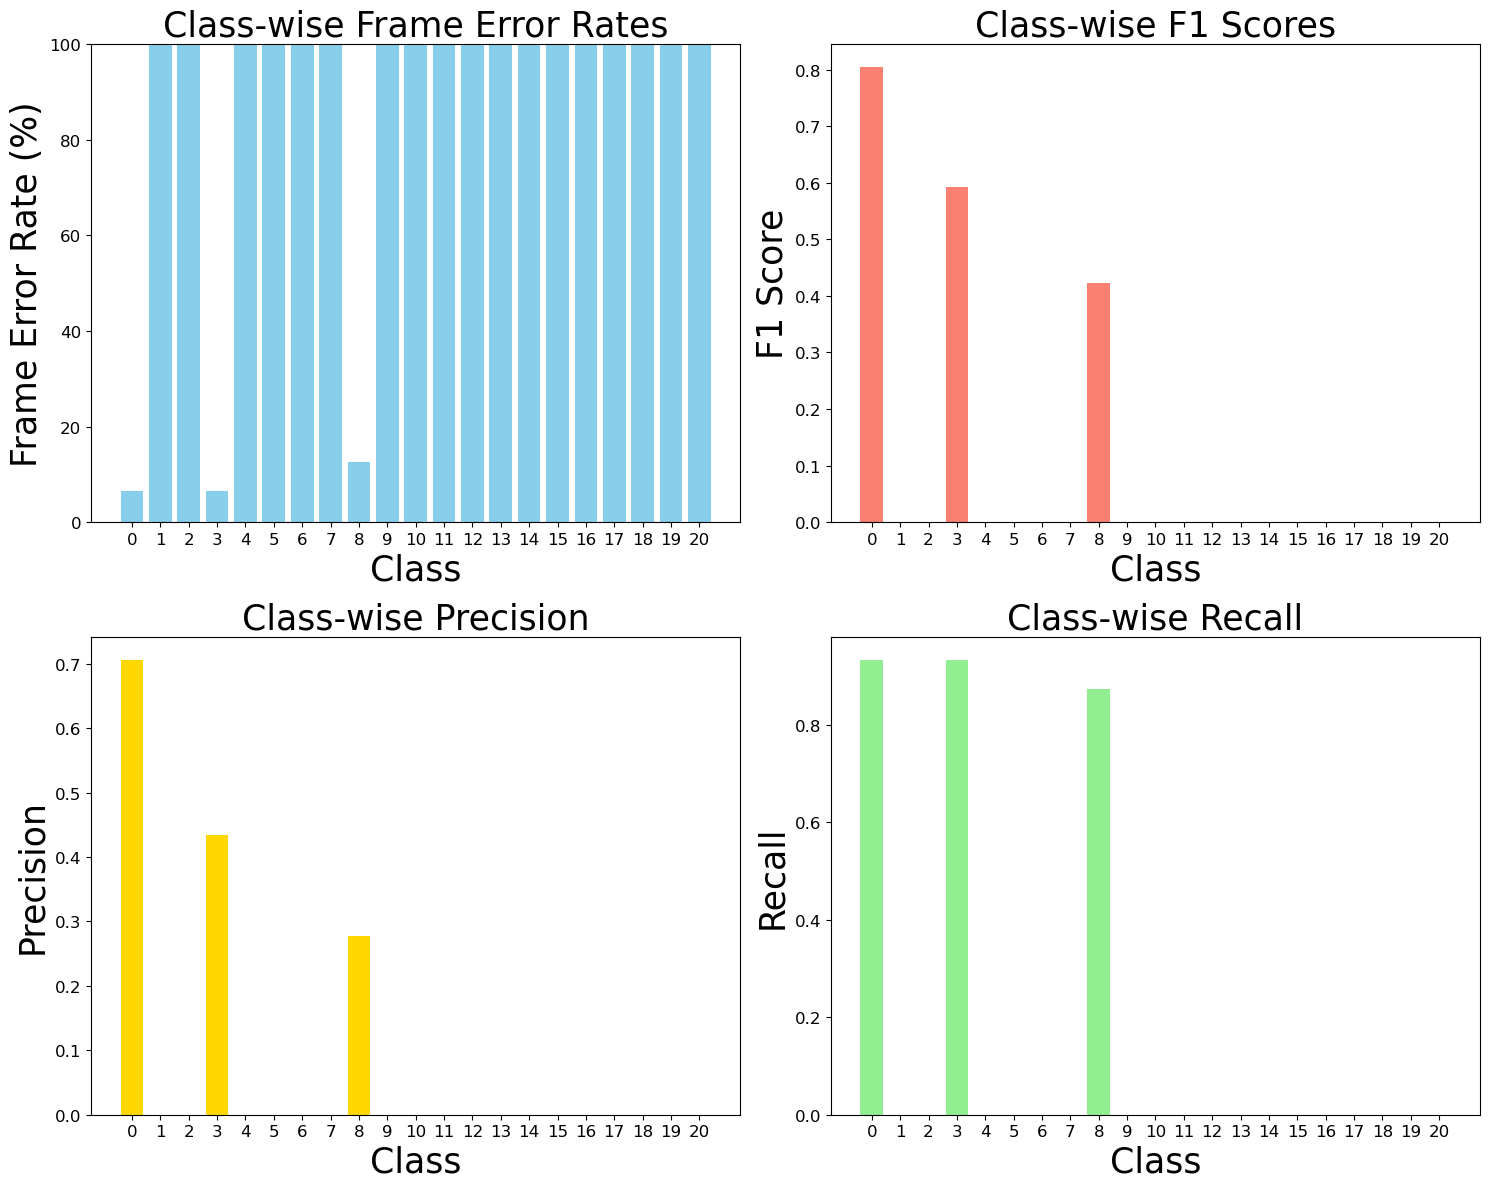

In [9]:
import torch
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

num_classes = 21  # Update this if the number of classes changes

def validate_model_multiple_passes(model, test_loader, num_passes=1, max_batches=100):
    model.eval()
    # Initialize metrics
    errors_per_class = [0] * num_classes
    correct_per_class = [0] * num_classes
    tp_per_class = [0] * num_classes
    fp_per_class = [0] * num_classes
    fn_per_class = [0] * num_classes
    total_frames = 0
    total_errors = 0

    total_iterations = num_passes * min(max_batches, len(test_loader))
    progress_bar = tqdm(total=total_iterations, desc="Evaluating", unit="batch")

    for _ in range(num_passes):  # Outer loop for multiple passes
        with torch.no_grad():
            for i, (spectrogram, label) in enumerate(test_loader):
                if i >= max_batches:  # Early stopping condition for each pass
                    break
                label = label.to(device)

                spectrogram = spectrogram[:,0,:,:]
                spectrogram = spectrogram.permute(0,2,1)
                spectrogram = spectrogram.reshape(-1,1 * 513)
                label = label.reshape(-1,num_classes)

                spectrogram = reducer.transform(spectrogram)
                spectrogram = torch.Tensor(spectrogram)
                spectrogram = spectrogram.to(device)

                output = model.forward(spectrogram)

                predicted_labels = output.argmax(dim=-1)
                true_labels = label.argmax(dim=-1)

                correct = (predicted_labels == true_labels)
                incorrect = ~correct

                for cls in range(num_classes):  # Iterate over the number of classes
                    class_mask = (true_labels == cls)
                    predicted_class_mask = (predicted_labels == cls)

                    correct_class = correct & class_mask
                    incorrect_class = incorrect & class_mask

                    tp = correct_class.sum().item()
                    fp = (predicted_class_mask & ~class_mask).sum().item()
                    fn = (class_mask & ~predicted_class_mask).sum().item()

                    tp_per_class[cls] += tp
                    fp_per_class[cls] += fp
                    fn_per_class[cls] += fn

                    correct_per_class[cls] += tp
                    errors_per_class[cls] += incorrect_class.sum().item()

                    total_frames += tp + incorrect_class.sum().item()
                    total_errors += incorrect_class.sum().item()

                progress_bar.update(1)  # Update progress bar after each batch

    progress_bar.close()  # Close the progress bar
    # Calculate Precision, Recall, and F1 score per class
    precision_per_class = {}
    recall_per_class = {}
    f1_scores_per_class = {}
    for cls in range(num_classes):
        precision = tp_per_class[cls] / (tp_per_class[cls] + fp_per_class[cls]) if tp_per_class[cls] + fp_per_class[cls] > 0 else 0
        recall = tp_per_class[cls] / (tp_per_class[cls] + fn_per_class[cls]) if tp_per_class[cls] + fn_per_class[cls] > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        precision_per_class[cls] = precision
        recall_per_class[cls] = recall
        f1_scores_per_class[cls] = f1_score

    # Calculate frame error rates, handling division by zero
    class_frame_error_rates = {
        cls: (errors / (errors + correct) * 100 if errors + correct > 0 else float('nan'))
        for cls, (errors, correct) in enumerate(zip(errors_per_class, correct_per_class))
    }

    total_frame_error_rate = (total_errors / total_frames * 100 if total_frames > 0 else float('nan'))
    print(f'Total Frame Error Rate: {total_frame_error_rate:.2f}%')

    class_occurrences = [(correct + errors) / total_frames * 100 for correct, errors in zip(correct_per_class, errors_per_class)]

    return class_frame_error_rates, class_occurrences, f1_scores_per_class, precision_per_class, recall_per_class

# Assuming model and test_loader have been defined and initialized correctly
class_frame_error_rates, class_occurrences, f1_scores_per_class, precision_per_class, recall_per_class = validate_model_multiple_passes(model, test_loader, num_passes=1, max_batches=1250)

# Plotting the class-wise frame error rates, F1 scores, Precision and Recall
classes = list(range(num_classes))
error_rates = [class_frame_error_rates.get(cls, float('nan')) for cls in classes]
f1_scores = [f1_scores_per_class.get(cls, float('nan')) for cls in classes]
precisions = [precision_per_class.get(cls, float('nan')) for cls in classes]
recalls = [recall_per_class.get(cls, float('nan')) for cls in classes]

plt.figure(figsize=(15, 12))

# Subplot 1: Error Rates
plt.subplot(2, 2, 1)
plt.bar(classes, error_rates, color='skyblue')
plt.xlabel('Class', fontsize=25)
plt.ylabel('Frame Error Rate (%)', fontsize=25)
plt.title('Class-wise Frame Error Rates', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)

# Subplot 2: F1 Scores
plt.subplot(2, 2, 2)
plt.bar(classes, f1_scores, color='salmon')
plt.xlabel('Class', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.title('Class-wise F1 Scores', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)

# Subplot 3: Precision
plt.subplot(2, 2, 3)
plt.bar(classes, precisions, color='gold')
plt.xlabel('Class', fontsize=25)
plt.ylabel('Precision', fontsize=25)
plt.title('Class-wise Precision', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)

# Subplot 4: Recall
plt.subplot(2, 2, 4)
plt.bar(classes, recalls, color='lightgreen')
plt.xlabel('Class', fontsize=25)
plt.ylabel('Recall', fontsize=25)
plt.title('Class-wise Recall', fontsize=25)
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()